## 3D Change Analysis at an Active Rock Glacier using Multitemporal Point Clouds

In this notebook, we will perform a surface change analysis on TLS point clouds of the Äußeres Hochebenkar rock glacier (46°50’11''N, 11°00’20‘’E) for two consecutive years. An introduction to the case study and dataset can be found in the e-learning course ETRAINEE [here](https://3dgeo-heidelberg.github.io/etrainee/data_usecases/usecase_rockglacier_ahk.html). 

[E-TRAINEE](https://github.com/3dgeo-heidelberg/etrainee) is an e-learning course on Time Series Analysis in Remote Sensing for Understanding Human-Environment Interactions. This course has been developed by research groups from four partner universities – Charles University, Heidelberg University, University of Innsbruck, and University of Warsaw. 

The objective is to perform a full workflow of 3D change analysis with

* Assessment of alignment uncertainty
* Change analysis using the M3C2 algorithm 
* Change representation and assessment of results
* For the fast ones: Comparison to change analysis via DEM differencing

Look into the article by [Zahs et al., 2019](https://doi.org/10.1002/ppp.2004) for comparison of possible surface dynamics at the site and help for deciding on suitable parameters, etc.

The workflow is  introduced throughout this notebook. Also, make use of the [software documentation](https://py4dgeo.readthedocs.io/en/latest/pythonapi.html)!
## Software and data
This task is solved using Python with the [`py4dgeo`](https://github.com/3dgeo-heidelberg/py4dgeo) library. 

You can use CloudCompare or GIS Software (e.g. QGIS) to check the data and visualize your results.

The dataset will be two epochs of point clouds acquired by UAV laser scanning in 2020 and 2021: `ahk/ahk_2020_uls.laz` and `ahk/ahk_2021_uls.laz`. Both point clouds [can be downloaded](https://zenodo.org/records/10003575) (module3.zip) from the E-learning course E-TRAINEE in the data directory `ahk`.

## Loading data

First, we start by setting up the Python environment and data:

In [1]:
# import required modules
import py4dgeo
import os
from pathlib import Path
import numpy as np
import laspy
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import pdal
import pooch

# Download data from zenodo and set path to point cloud folder
p = pooch.Pooch(base_url="doi:10.5281/zenodo.10003574/", path=pooch.os_cache("py4dgeo"))
p.load_registry_from_doi()
p.fetch("module3.zip", processor=pooch.Unzip())
pc_dir = os.path.join(p.path, "module3.zip.unzip/module3/ahk")

# list of point clouds (time series)
pc_list = os.listdir(pc_dir)
pc_list[:5]  # print the first elements

['ahk_2020_uls.laz',
 'ahk_2021_photo.laz',
 'ahk_2021_uls.laz',
 'ahk_2021_uls_stableparts.dbf',
 'ahk_2021_uls_stableparts.shp']

Specify the path to the data and names of input files, and read in the point cloud data:

In [2]:
# derive the file paths and read in the data
pc_file_2020 = f"{pc_dir}/ahk_2020_uls.laz"
pc_file_2021 = f"{pc_dir}/ahk_2021_uls.laz"

In [3]:
# define function to read las file
def read_las(infile, get_attributes=False, use_every=1):
    """
    Function to read coordinates and optionally attribute information of point cloud data from las/laz file.

    :param infile: specification of input file (format: las or laz)
    :param get_attributes: if True, will return all attributes in file, otherwise will only return coordinates (default is False)
    :param use_every: value specifies every n-th point to use from input, i.e. simple subsampling (default is 1, i.e. returning every point)
    :return: Array of point coordinates of shape (N,3) with N number of points in input file (or subsampled by 'use_every')
    """

    # read the file using the laspy read function
    indata = laspy.read(infile)

    # get the coordinates (XYZ) and stack them in a 3D array
    coords = np.vstack((indata.x, indata.y, indata.z)).transpose()

    # subsample the point cloud, if use_every = 1 will remain the full point cloud data
    coords = coords[::use_every, :]

    # read attributes if get_attributes is set to True
    if get_attributes == True:
        # get all attribute names in the las file as list
        las_fields = list(indata.points.point_format.dimension_names)

        # create a dictionary to store attributes
        attributes = {}

        # loop over all available fields in the las point cloud data
        for las_field in las_fields[
            3:
        ]:  # skip the first three fields, which contain coordinate information (X,Y,Z)
            attribute = np.array(
                indata.points[las_field]
            )  # transpose shape to (N,1) to fit coordinates array
            if np.sum(attribute) == 0:  # if field contains only 0, it is empty
                continue
            # add the attribute to the dictionary with the name (las_field) as key
            attributes[las_field] = attribute[
                ::use_every
            ]  # subsample by use_every, corresponding to point coordinates

        # return coordinates and attribute data
        return (coords, attributes)

    else:  # get_attributes == False
        return coords  # return coordinates only


# read the point clouds into numpy arrays
pc_2020 = read_las(pc_file_2020)
pc_2021 = read_las(pc_file_2021)

## Assessment of alignment uncertainty
The epochs are georeferenced, i.e., multitemporal point clouds are registered in a common coordinate reference frame. The point clouds have further been fine aligned using an ICP method on stable parts outside the rock glacier area. You may assume that the best possible alignment between the multitemporal data has been achieved.

For change analysis, it is important to assess the uncertainty of the point cloud alignment for information on the minimum detectable change. Do this by cutting out some stable rock surfaces outside the rock glacier and checking the cloud-to-cloud distances for these subsets. You may cut out point cloud subsets manually in CloudCompare, or define polygons (e.g., in QGIS) to extract the parts from the full point cloud in the Python workflow.

We check the alignment uncertainty by cutting out some stable rock surfaces outside the rock glacier. In this solution, we have derived polygons of stable parts for one point cloud epoch (`ahk_2021_uls_stableparts.shp`). Using this, we can extract the points within stable parts (2D query) and subsequently derive the point cloud distances between epochs. 

In [4]:
# specify input shapefile
shp_file = f"{pc_dir}/ahk_2021_uls_stableparts.shp"

# read the shapefile
datasource = gpd.read_file(shp_file)

In the next part, we check each remaining point for its position in the polygon/stable area.

In [5]:
print("Mask stable parts via polygons for 2020 points...")
pc_2020_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(pc_2020[:, 0], pc_2020[:, 1], pc_2020[:, 2]), crs='EPSG:25832')
pts_in_poly_2020_gdf = gpd.sjoin(pc_2020_gdf, datasource, predicate="within")
pc_stable_2020 = pc_2020[pts_in_poly_2020_gdf.index]

print("Mask stable parts via polygons for 2021 points...")
pc_2021_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(pc_2021[:, 0], pc_2021[:, 1], pc_2021[:, 2]), crs='EPSG:25832')
pts_in_poly_2021_gdf = gpd.sjoin(pc_2021_gdf, datasource, predicate="within")
pc_stable_2021 = pc_2021[pts_in_poly_2021_gdf.index]
print(
    f"Remaining points: {pc_stable_2020.shape[0]}/{pc_2020.shape[0]} for 2020; {pc_stable_2021.shape[0]}/{pc_2021.shape[0]} for 2021"
)

Mask stable parts via polygons for 2020 points...
Mask stable parts via polygons for 2021 points...
Remaining points: 330254/37426631 for 2020; 409231/45662285 for 2021


Create a kd tree and compute the distances:

In [6]:
# create a 3D kd-tree from the point cloud
tree2021 = KDTree(pc_stable_2021[:, :3])

# query indices of nearest neighbors of 2020 coordinates in 2021 kd-tree
nn_dists = tree2021.query(pc_stable_2020[:, :3], k=1)

# obtain distances as first element in tuple returned by query above
distances = nn_dists[0]

We assess the distances visually, and derive the statistics:

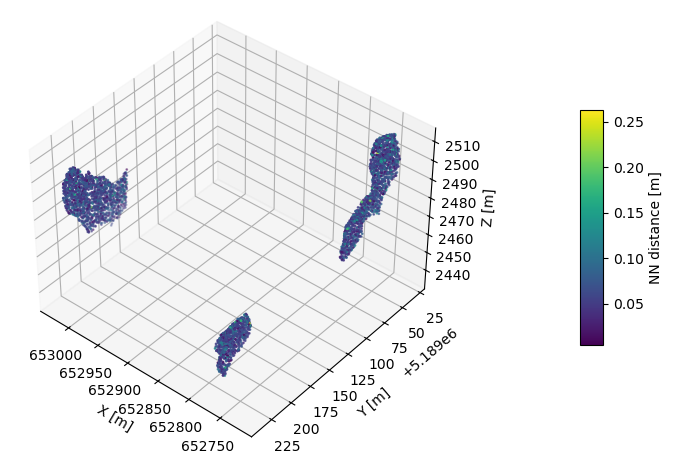

In [7]:
# allow interactive rotation in notebook
%matplotlib inline

# create a figure with 3D axis
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

nth = 100

# plot the point cloud colored by height (z values)
s = ax.scatter(
    pc_stable_2020[::nth, 0],
    pc_stable_2020[::nth, 1],
    pc_stable_2020[::nth, 2],
    s=1,
    c=distances[::nth],
)

# label axes and add title
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")

# set initial view of 3D plot
ax.view_init(elev=40.0, azim=130.0)

# add a colorbar
fig.colorbar(s, shrink=0.5, aspect=10, label="NN distance [m]", ax=ax, pad=0.2)

# show the plot
plt.tight_layout()
plt.show()

In [8]:
# print statistics of nn distances
print(f"Median distances: {np.median(distances):.3f} m")
print(f"Std. dev. of distances: {np.std(distances):.3f} m")

Median distances: 0.060 m
Std. dev. of distances: 0.151 m


The distances are quite large according to the statistics. We would assume lower values for the (visual) quality of the co-registration and the measurement accuracy of UAV laser scanning in this scene. An explanation for the large values could be the influence of point sampling, so you see here an effect of the drawbacks in simple cloud-to-cloud (C2C) distance computation. For a potentially more robust result, we derive the M3C2 distances in these stable parts (for a detailed solution how to establish the M3C2 change analysis, see the remainder of the solution).

In [9]:
# load the stable parts as py4dgeo Epochs
epoch2020_stable = py4dgeo.epoch.as_epoch(pc_stable_2020)
epoch2021_stable = py4dgeo.epoch.as_epoch(pc_stable_2021)

# instantiate the M3C2 algorithm object, using all points of 2020 as corepoints (no subsampling)
m3c2 = py4dgeo.M3C2(
    epochs=(epoch2020_stable, epoch2021_stable),
    corepoints=epoch2020_stable.cloud[::],
    normal_radii=(0.5,),
    cyl_radii=(0.5,),
    max_distance=(5.0),
    registration_error=(0.0),
)

# run the distance computation
m3c2_distances_stableparts, uncertainties_stableparts = m3c2.run()

# print statistics of nn distances
print(f"Median M3C2 distances: {np.nanmedian(m3c2_distances_stableparts):.3f} m")
print(f"Std. dev. of M3C2 distances: {np.nanstd(m3c2_distances_stableparts):.3f} m")

[2023-12-04 13:18:18][INFO] Initializing Epoch object from given point cloud
[2023-12-04 13:18:18][INFO] Initializing Epoch object from given point cloud
[2023-12-04 13:18:18][INFO] Building KDTree structure with leaf parameter 10
[2023-12-04 13:18:18][INFO] Building KDTree structure with leaf parameter 10
Median M3C2 distances: -0.013 m
Std. dev. of M3C2 distances: 0.037 m


As the M3C2 distances provide a more robust etimate of point distances in the stable parts, we use their standard deviation as measure of alignment accuracy in our change analysis. This measure we can later on use as registration error for deriving the level of detection.

In [10]:
reg_2020_2021 = np.nanstd(m3c2_distances_stableparts)
print(
    f"Registration error based on point distances in stable parts is {reg_2020_2021:.3f} m."
)

Registration error based on point distances in stable parts is 0.037 m.


This value already provides as an estimate of change magnitudes which can be confidently derived from point cloud comparison of these two epochs. In the M3C2 distance calculation, we will derive the per-point level of detection considering the local (i.e. spatially variable) roughness and point density.

By the way, we can free up some working memory by removing the point cloud arrays here. In the following, we continue with `py4dgeo` and therefore load the data into (new) `Epoch`objects.

In [11]:
pc_2020 = None
pc_2021 = None
pc_2020_subs = None
pc_2021_subs = None
pc_stable_2020 = None
pc_stable_2021 = None

## 3D change analysis via point cloud distance computation

Calculate the distance between point clouds of the two epochs using the M3C2 algorithm ([Lague et al., 2013](https://doi.org/10.1016/j.isprsjprs.2013.04.009  )). 

Think about a suitable parametrization:
* Normal scale D: diameter of point neighborhood to use for normal vector computation. *Hint*: Aim for overall, larger-scale surface change, e.g. due to rock glacier creep or heave/thaw (instead of individual boulders).
* Projection scale d: diameter of cylindrical point neighborhood to obtain average position.
* Maximum cylinder depth: Maximum distance along normal at which to obtain distances to the other point cloud.
* Preferred normal orientation.
* Registration error ~ alignment accuracy

Consider using the [py4dgeo documentation](https://py4dgeo.readthedocs.io/en/latest/intro.html).

To perform the M3C2 change analyis with py4dgeo, we need to read the data into `Epoch` objects. This can be done from the `Nx3` array of coordinates using the function `py4dgeo.epoch.as_epoch()`, or directly from file using `py4dgeo.read_from_las()`.

In [12]:
# load epochs into py4dgeo objects
epoch2020 = py4dgeo.read_from_las(pc_file_2020)
epoch2021 = py4dgeo.read_from_las(pc_file_2021)

[2023-12-04 13:18:21][INFO] Reading point cloud from file 'C:\Users\wq452\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/ahk/ahk_2020_uls.laz'
[2023-12-04 13:18:23][INFO] Reading point cloud from file 'C:\Users\wq452\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/ahk/ahk_2021_uls.laz'


As core points, we use a subsampling of coordinates in the epoch of 2020 (which will be the reference for deriving M3C2 distances to the later epoch of 2021), e.g. using every 100th point.

In [13]:
# use every nth point as core point for distance calculation
corepoints = epoch2020.cloud[::100]

We parametrize the M3C2 algorithm object according to the parameters in [Zahs et al., 2019](#references), and use the registration error we derived above. The default normal orientation in `py4dgeo` is upwards (`up`), so we do not need to adapt/set this parameter.

In [14]:
# instantiate and parametrize the M3C2 algorithm object
m3c2 = py4dgeo.M3C2(
    epochs=(epoch2020, epoch2021),
    corepoints=corepoints,
    normal_radii=(4.0, 0.5, 6.0),
    cyl_radii=(0.5,),
    max_distance=(15.0),
    registration_error=(reg_2020_2021),
)

Now the analysis can be run - you may have a coffee break in the meantime ;-)

In [15]:
m3c2_distances, uncertainties = m3c2.run()

[2023-12-04 13:18:26][INFO] Building KDTree structure with leaf parameter 10
[2023-12-04 13:18:41][INFO] Building KDTree structure with leaf parameter 10


All change information (distances and uncertainties) are now contained in the returned objects.

## Change representation and assessment of results

Visualize the obtained point cloud distances and corresponding information layers, such as the level of detection and the normal vectors representing the direction of changes.

Prepare the result assessment for interpretation by analysts. For example, you may rasterize the different layers and create a map, e.g., of the derived surface changes in GIS software. Tip: Use the Web Map Service (WMS) of Tyrol as a basemap: [https://gis.tirol.gv.at/arcgis/services/Service_Public/orthofoto/MapServer/WMSServer](https://gis.tirol.gv.at/arcgis/services/Service_Public/orthofoto/MapServer/WMSServer).


What are the different properties of visible changes and to which types of surface activity would you attribute them? Think of heave and subsidence processes, individual boulder movement, and rock glacier creep (cf. [Zahs et al., 2019](#references)).

Using the level of detection computed by the M3C2, we derive for each point if the quantified change is significant:

In [16]:
# create a binary mask of significant change
change_sign = np.where(abs(m3c2_distances) > uncertainties["lodetection"], True, False)

Now we create a composite figure of the change values (distances), change directions (vertical component), level of detection and significant change:

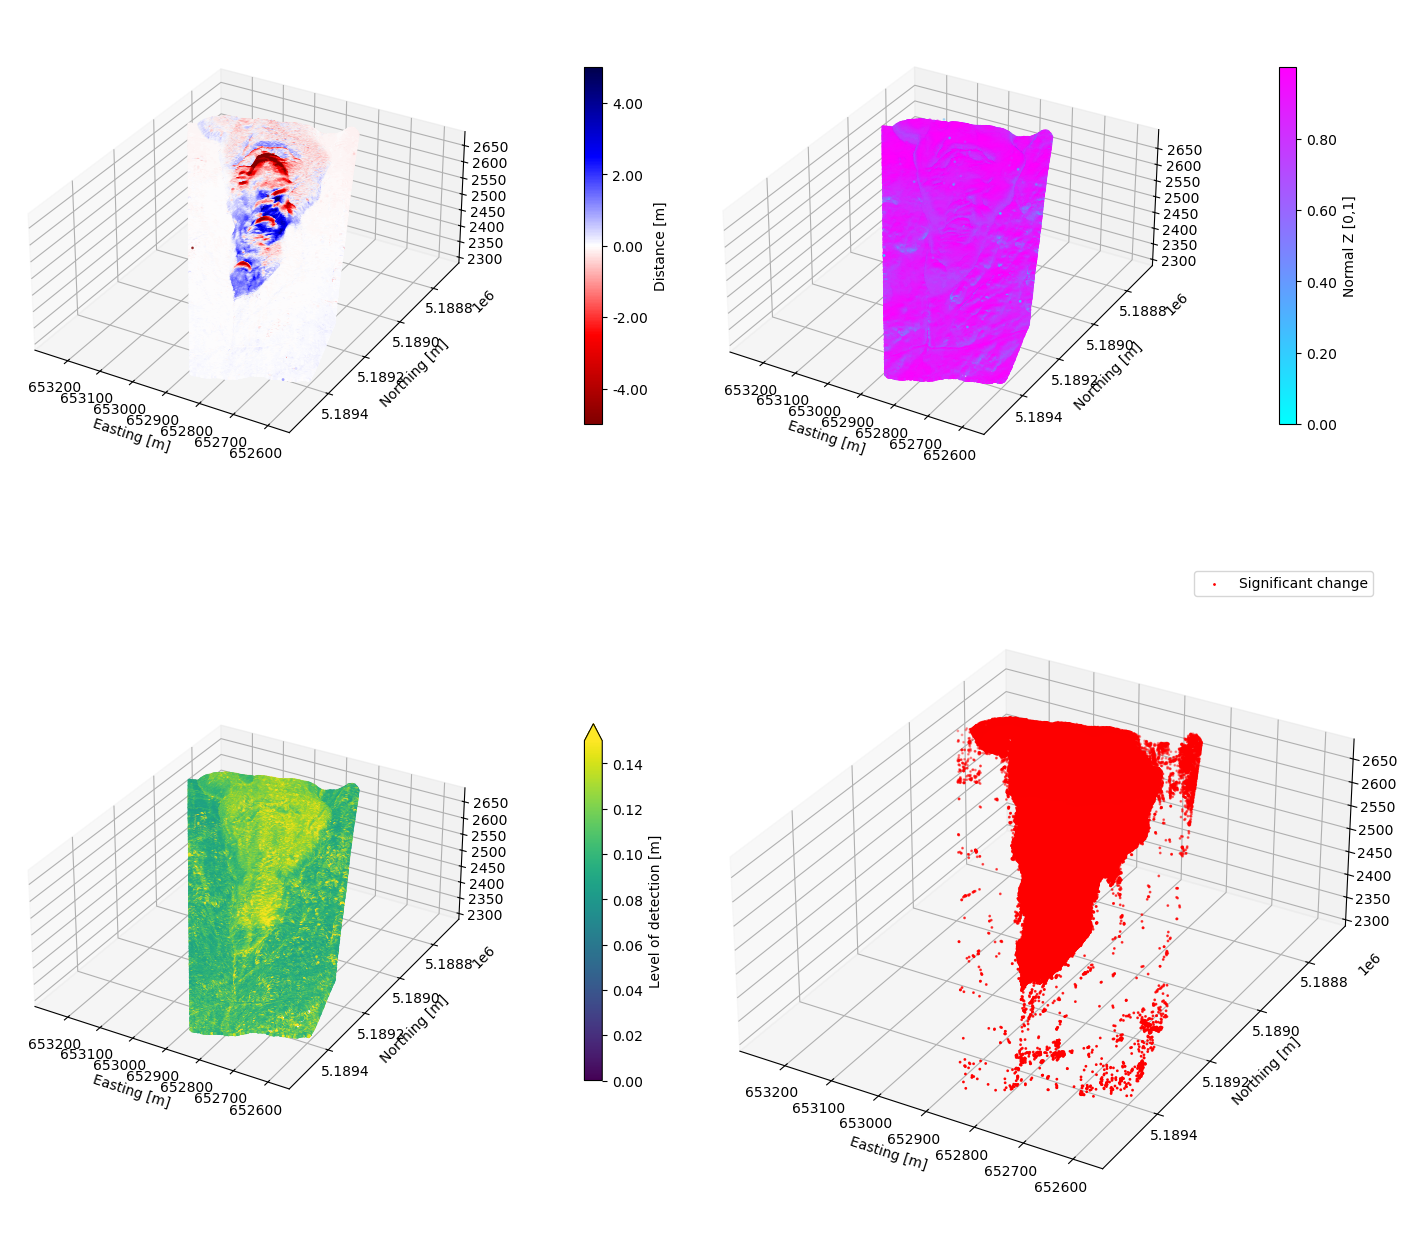

In [20]:
# create the figure
fig, axs = plt.subplots(2, 2, figsize=(14, 14), subplot_kw={"projection": "3d"})
(ax1, ax2), (ax3, ax4) = axs

# plot the distances
d = ax1.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=m3c2_distances,
    cmap="seismic_r",
    vmin=-5.0,
    vmax=5.0,
    s=1,
)
plt.colorbar(d, format=("%.2f"), label="Distance [m]", ax=ax1, shrink=0.5, pad=0.15)

# plot the directions
directions = m3c2.directions()
dz = ax2.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=directions[:, 2],
    cmap="cool",
    s=1,
)
plt.colorbar(dz, format=("%.2f"), label="Normal Z [0,1]", ax=ax2, shrink=0.5, pad=0.15)

# plot the level of detection values
l = ax3.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=uncertainties["lodetection"],
    cmap="viridis",
    vmin=0.,
    vmax=0.15,
    s=1,
)
plt.colorbar(
    l,
    format=("%.2f"),
    label="Level of detection [m]",
    ax=ax3,
    extend="max",
    shrink=0.5,
    pad=0.15,
)

# plot the significant change values (boolean)
# ax4.scatter(corepoints[~change_sign][:,0], corepoints[~change_sign][:,1], corepoints[~change_sign][:,2], label='Not significant change', c='blue', s=1) # if added, visibility of significant change areas is poor
ax4.scatter(
    corepoints[change_sign][:, 0],
    corepoints[change_sign][:, 1],
    corepoints[change_sign][:, 2],
    label="Significant change",
    c="red",
    s=1,
)
ax4.legend()

# add plot elements
for ax_set in axs:
    for ax in ax_set:
        ax.set_xlabel("Easting [m]")
        ax.set_ylabel("Northing [m]")
        ax.set_aspect("equal")
        ax.view_init(elev=30.0, azim=120.0)

plt.axis("equal")
plt.tight_layout()
plt.show()

For further analysis and visualization in external software, we store the result in one point cloud as laz file, adding all the attributes of the change analysis result:

In [21]:
# define path for the las file
pc_m3c2 = f"{pc_dir}/ahk_2020_2021_m3c2.laz"

# create a dictionary of attributes to store with the point cloud
attr = {
    "m3c2_distance": m3c2_distances,
    "level_of_detection": uncertainties["lodetection"],
    "significant_change": change_sign.astype(int),
    "NormalX": directions[:, 0],
    "NormalY": directions[:, 1],
    "NormalZ": directions[:, 2],
}


# define function to write las file
def write_las(outpoints, outfilepath, attribute_dict={}, correct_wkt_entry=True):
    """
    :param outpoints: 3D array of points to be written to output file
    :param outfilepath: specification of output file (format: las or laz)
    :param attribute_dict: dictionary of attributes (key: name of attribute; value: 1D array of attribute values in order of points in 'outpoints'); if not specified, dictionary is empty and nothing is added
    :return: None
    """

    # create a header for new las file
    hdr = laspy.LasHeader(version="1.4", point_format=6)

    # set the coordinate resolutions and offset in the header
    hdr.x_scale = 0.00025
    hdr.y_scale = 0.00025
    hdr.z_scale = 0.00025
    mean_extent = np.mean(outpoints, axis=0)
    hdr.x_offset = int(mean_extent[0])
    hdr.y_offset = int(mean_extent[1])
    hdr.z_offset = int(mean_extent[2])

    # create the las data
    las = laspy.LasData(hdr)

    # write coordinates into las data
    las.x = outpoints[:, 0]
    las.y = outpoints[:, 1]
    las.z = outpoints[:, 2]

    # add all dictionary entries to las data (if available)
    for key, vals in attribute_dict.items():
        if not key in las:
            las.add_extra_dim(laspy.ExtraBytesParams(name=key, type=type(vals[0])))
        las[key] = vals

    # write las file
    las.write(outfilepath)

    # this is required because alobal encoding WKT flag must be set for point format 6 - 10 since las 1.4
    # otherwise programs such as pdal will not be able to read the file
    if correct_wkt_entry:
        filename = outfilepath
        f = open(filename, "rb+")
        f.seek(6)
        f.write(bytes([17, 0, 0, 0]))
        f.close()

    return


# use las write function to write file
write_las(corepoints, pc_m3c2, attribute_dict=attr)

To create raster layers for further analysis and visualization in a GIS, we use [PDAL](https://pdal.io/en/latest/stages/writers.gdal.html).

In [22]:
# replacing backslashes by forward slashes is required for some Windows paths
pc_m3c2 = pc_m3c2.replace("\\", "/")

# define the raster file names based on the input file name
raster_distance = pc_m3c2.replace(".laz", "_distances.tif")
raster_lodet = pc_m3c2.replace(".laz", "_lodetection.tif")

# define the pdal pipeline as json, "dimension" allows us to define the attribute to be rasterized (default: "Z" value / elevation)
json_rast = """[
    "%s",
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":1.0,
        "dimension":"%s",
        "window_size":8
    }
]"""

# execute the pipeline for the distance raster
json_dist = json_rast % (pc_m3c2, raster_distance, "m3c2_distance")
pipeline = pdal.Pipeline(json_dist)
exe = pipeline.execute()

# execute the pipeline for the lodetection raster
json_lodet = json_rast % (pc_m3c2, raster_lodet, "level_of_detection")
pipeline = pdal.Pipeline(json_lodet)
exe = pipeline.execute()

You can now create useful raster-based map visualizations as well, e.g. in QGIS. In the corresponding [solution video](https://www.youtube.com/embed/6TTyI-SuDlw) you can see how this is done.

## References

* Lague, D., Brodu, N., & Leroux, J. (2013). Accurate 3D comparison of complex topography with terrestrial laser scanner: Application to the Rangitikei canyon (N-Z). ISPRS Journal of Photogrammetry and Remote Sensing, 82, pp. 10-26. doi: [10.1016/j.isprsjprs.2013.04.009  ](https://doi.org/10.1016/j.isprsjprs.2013.04.009  ).

* Zahs, V., Hämmerle, M., Anders, K., Hecht, S., Sailer, R., Rutzinger, M., Williams, J. G., & Höfle, B. (2019). Multi-temporal 3D point cloud-based quantification and analysis of geomorphological activity at an alpine rock glacier using airborne and terrestrial LiDAR. Permafrost and Periglacial Processes, 30 (3), pp. 222-238. doi: [10.1002/ppp.2004  ](https://doi.org/10.1002/ppp.2004  ).